In [2]:
import plotly.plotly as py
import plotly.graph_objs as graph_objs

import cufflinks as cf

import pandas as pd
import numpy as np

import sqlite3
from sqlalchemy import create_engine

In [3]:
engine = create_engine('sqlite:///liligo.db', echo=False)

# Let's see how prices go up for a weekend in January
we only have one snapshot per month, so the analysis won't be exact, and have to apply some approximations
* first check the price of the second weekend in January (18-20), booked at different times -- one date per month from sep to dec
* next check how the price of the consecutive weekends changes (jan 25-27 and feb 1-3)

In [33]:
dates = [('2019-01-18', '2019-01-20'), ('2019-01-25', '2019-01-27'), ('2019-02-01', '2019-02-03')]
months = ['jan', 'dec', 'nov', 'oct', 'sep']

In [55]:
mapper = {'2019-01-18': '1 week left', '2019-01-25': '2 weeks left', '2019-02-01':'3 weeks left'}
mapper

{'2019-01-18': '1 week left',
 '2019-01-25': '2 weeks left',
 '2019-02-01': '3 weeks left'}

## Booked months ahead

### bottom percentile

In [34]:
for (date_from, date_to) in [('2019-01-18', '2019-01-20')]:
    q3_list = []
    cnt_list = []
    for month in months:
        sql = '''
            with cal as (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 

            select 
                price_per_night as q3_price_per_night
            from cal
            order by q3_price_per_night
            limit 1
            offset (select count(*) from cal) / 4
        '''.format('calendar_' + month, date_from, date_to)
        q3 = pd.read_sql_query(sql, engine)
        q3_list.append((month, q3.loc[0, 'q3_price_per_night']))
        
        sql = '''
            select count(*) as cnt
            from (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 
        '''.format('calendar_' + month, date_from, date_to)
        cnt = pd.read_sql_query(sql, engine)
        cnt_list.append((month, cnt.loc[0, 'cnt']))
    
    print(date_from, date_to)
    print('bottom 25 percentile price: ', q3_list)
    print('number of listings for the weened: ',  cnt_list)
    print()

2019-01-18 2019-01-20
bottom 25 percentile price:  [('jan', 79.0), ('dec', 75.0), ('nov', 70.0), ('oct', 70.0), ('sep', 69.0)]
number of listings for the weened:  [('jan', 4073), ('dec', 10148), ('nov', 14745), ('oct', 14351), ('sep', 16949)]



### median

In [35]:
for (date_from, date_to) in [('2019-01-18', '2019-01-20')]:
    q4_list = []
    for month in months:
        sql = '''
            with cal as (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 

            select 
                price_per_night as median_price_per_night
            from cal
            order by median_price_per_night
            limit 1
            offset (select count(*) from cal) / 2
        '''.format('calendar_' + month, date_from, date_to)
        q4 = pd.read_sql_query(sql, engine)
        q4_list.append((month, q4.loc[0, 'median_price_per_night']))
    
    print(date_from, date_to)
    print('median percentile price: ', q4_list)
    print()

2019-01-18 2019-01-20
median percentile price:  [('jan', 119.0), ('dec', 104.0), ('nov', 100.0), ('oct', 100.0), ('sep', 99.0)]



### top percentile

In [36]:
for (date_from, date_to) in [('2019-01-18', '2019-01-20')]:
    q1_list = []
    for month in months:
        sql = '''
            with cal as (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 

            select 
                price_per_night as q1_price_per_night
            from cal
            order by q1_price_per_night
            limit 1
            offset (select count(*) from cal) / 4 * 3
        '''.format('calendar_' + month, date_from, date_to)
        q1 = pd.read_sql_query(sql, engine)
        q1_list.append((month, q1.loc[0, 'q1_price_per_night']))

    
    print(date_from, date_to)
    print('top 25 percentile price: ', q1_list)
    print()

2019-01-18 2019-01-20
top 25 percentile price:  [('jan', 200.0), ('dec', 175.0), ('nov', 160.0), ('oct', 160.0), ('sep', 155.0)]



In [101]:
q3_prices = (
    pd
    .DataFrame([('jan', 79.0), ('dec', 75.0), ('nov', 70.0), ('oct', 70.0), ('sep', 69.0)], columns = ['month', 'q3_price_1w'])
    .set_index('month')
)
#q3_prices

In [102]:
median_prices = (
    pd
    .DataFrame([('jan', 119.0), ('dec', 104.0), ('nov', 100.0), ('oct', 100.0), ('sep', 99.0)], columns = ['month', 'median_price_1w'])
    .set_index('month')
)
#median_prices

In [103]:
q1_prices = (
    pd
    .DataFrame([('jan', 200.0), ('dec', 175.0), ('nov', 160.0), ('oct', 160.0), ('sep', 155.0)], columns = ['month', 'q1_price_1w'])
    .set_index('month')
)
#q1_prices

In [104]:
(
    pd.concat([
        q1_prices.rename(columns = {'q1_price_1w': 'top 25 perc price'}),
        median_prices.rename(columns = {'median_price_1w': 'median price'}), 
        q3_prices.rename(columns = {'q3_price_1w': 'bottom 25 perc price'}),
    ], axis = 1, sort=False)
    [::-1]
)

,top 25 perc price,median price,bottom 25 perc price
month,,,
sep,155.0,99.0,69.0
oct,160.0,100.0,70.0
nov,160.0,100.0,70.0
dec,175.0,104.0,75.0
jan,200.0,119.0,79.0


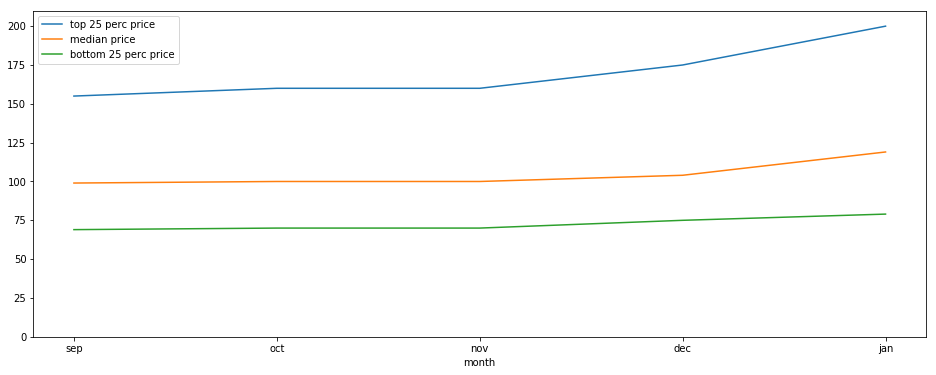

In [105]:
(
    pd.concat([
        q1_prices.rename(columns = {'q1_price_1w': 'top 25 perc price'}),
        median_prices.rename(columns = {'median_price_1w': 'median price'}), 
        q3_prices.rename(columns = {'q3_price_1w': 'bottom 25 perc price'}),
    ], axis = 1, sort=False)
    [::-1]
    .plot(figsize = (16, 6), ylim = (0, 210), xticks = range(len(q1_prices)))
);

In [37]:
room_tyes = pd.read_sql_query('select id, room_type from listings', con=engine)

In [38]:
room_tyes.to_sql('room_types', con=engine, if_exists='replace')

In [26]:
pd.read_sql_query('''
            select
                  rooms.room_type
                , count(*) as cnt
            from (
                select listing_id
                from calendar_jan
                where 1=1
                    and date between '2019-01-18' and '2019-01-20'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't' 
            ) cal
            join room_types rooms
                on cal.listing_id = rooms.id
            group by room_type
        ''', engine)

,room_type,cnt
0,Entire home/apt,2742
1,Private room,868
2,Shared room,103


In [15]:
pd.read_sql_query('select * from calendar_feb limit 1', con=engine)

,index,listing_id,date,available,minimum_nights,maximum_nights,price_usd
0,0,2577,2019-02-05,f,3.0,1125.0,125.0


# Number of listings

## Booked months ahead

In [54]:
cnt_list = []
for month in months:
    if month == 'jan':
        continue
        
    sql = '''
        select count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '2019-01-18' and '2019-01-20'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) 
    '''.format('calendar_' + month)
    cnt = pd.read_sql_query(sql, engine)
    cnt_list.append(('booked in ' + month, cnt.loc[0, 'cnt']))

print('number of listings for the weened: ',  cnt_list)

number of listings for the weened:  [('booked in dec', 10148), ('booked in nov', 14745), ('booked in oct', 14351), ('booked in sep', 16949)]


## Different February weekeds booked on the same day in Feb

In [57]:
cnt_feb = []
for (date_from, date_to) in dates:
    sql = '''
        select count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from calendar_jan
            where 1=1
                and date between '{}' and '{}'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) 
    '''.format(date_from, date_to)
    cnt = pd.read_sql_query(sql, engine)
    cnt_feb.append((mapper[date_from], cnt.loc[0, 'cnt']))

print('number of listings for the weened: ',  cnt_feb)

number of listings for the weened:  [('1 week left', 4073), ('2 weeks left', 8421), ('3 weeks left', 10193)]


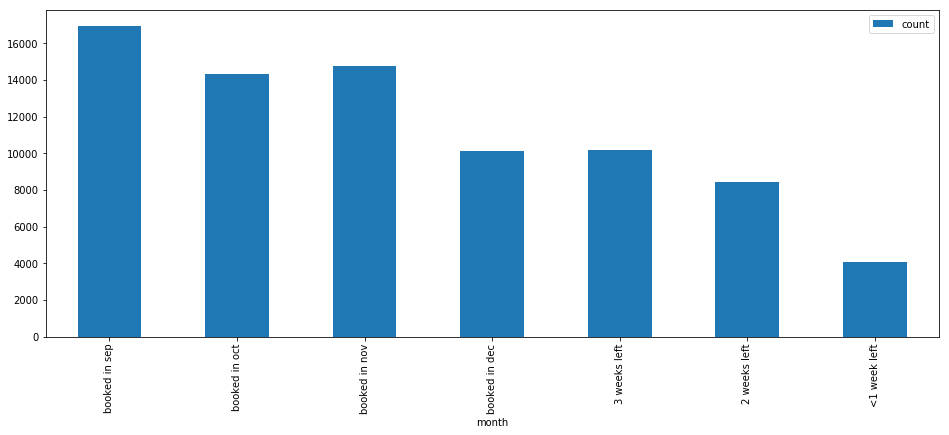

In [160]:
(
    pd
    .concat([
        pd.DataFrame([('<1 week left', 4073), ('2 weeks left', 8421), ('3 weeks left', 10193)], columns = ['month', 'count']),
        pd.DataFrame([('booked in dec', 10148), ('booked in nov', 14745), ('booked in oct', 14351), ('booked in sep', 16949)], columns = ['month', 'count'])
        ])
    .set_index('month')
    [::-1]
    .plot(kind = 'bar', figsize = (16, 6))
);

# Let's repeat the same thing for a summer weenend

In [136]:
dates = [('2018-09-14', '2018-09-16'), ('2018-09-21', '2018-09-23'), ('2018-09-28', '2018-09-30')]
months = ['aug', 'jul', 'jun']

In [137]:
mapper = {'2018-09-14': '<1 week left', '2018-09-21': '2 weeks left', '2018-09-28':'3 weeks left'}
mapper

{'2018-09-14': '<1 week left',
 '2018-09-21': '2 weeks left',
 '2018-09-28': '3 weeks left'}

## Top quartile, median and bottom quartile of the prices over time

In [138]:
for (date_from, date_to) in dates[:1]:
    q3_list = []
    cnt_list = []
    for month in months:
        sql = '''
            with cal as (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 

            select 
                price_per_night as q3_price_per_night
            from cal
            order by q3_price_per_night
            limit 1
            offset (select count(*) from cal) / 4
        '''.format('calendar_' + month, date_from, date_to)
        q3 = pd.read_sql_query(sql, engine)
        q3_list.append((month, q3.loc[0, 'q3_price_per_night']))
    
    print('bottom 25 percentile price: ', q3_list)

bottom 25 percentile price:  [('aug', 65.0), ('jul', 65.0), ('jun', 70.0)]


In [139]:
for (date_from, date_to) in dates[:1]:
    q4_list = []
    for month in months:
        sql = '''
            with cal as (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 

            select 
                price_per_night as median_price_per_night
            from cal
            order by median_price_per_night
            limit 1
            offset (select count(*) from cal) / 2
        '''.format('calendar_' + month, date_from, date_to)
        q4 = pd.read_sql_query(sql, engine)
        q4_list.append((month, q4.loc[0, 'median_price_per_night']))
    
    print(date_from, date_to)
    print('median percentile price: ', q4_list)
    print()

2018-09-14 2018-09-16
median percentile price:  [('aug', 95.0), ('jul', 92.0), ('jun', 100.0)]



In [140]:
for (date_from, date_to) in dates[:1]:
    q1_list = []
    for month in months:
        sql = '''
            with cal as (
                select listing_id, min(price_usd) as price_per_night
                from {}
                where 1=1
                    and date between '{}' and '{}'
                group by listing_id
                having max(available) == 't'
                    and min(available) == 't'
                ) 

            select 
                price_per_night as q1_price_per_night
            from cal
            order by q1_price_per_night
            limit 1
            offset (select count(*) from cal) / 4 * 3
        '''.format('calendar_' + month, date_from, date_to)
        q1 = pd.read_sql_query(sql, engine)
        q1_list.append((month, q1.loc[0, 'q1_price_per_night']))

    
    print(date_from, date_to)
    print('top 25 percentile price: ', q1_list)
    print()

2018-09-14 2018-09-16
top 25 percentile price:  [('aug', 160.0), ('jul', 150.0), ('jun', 160.0)]



## Top quartile, median and bottom quartile of the prices of different February weekends

In [141]:
q3_list = []

for (date_from, date_to) in dates:
    sql = '''
        with cal as (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '{}' and '{}'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) 

        select 
            price_per_night as q3_price_per_night
        from cal
        order by q3_price_per_night
        limit 1
        offset (select count(*) from cal) / 4
    '''.format('calendar_sep', date_from, date_to)
    q3 = pd.read_sql_query(sql, engine)
    q3_list.append((mapper[date_from], q3.loc[0, 'q3_price_per_night']))
    
print('bottom 25 percentile price: ', q3_list)

bottom 25 percentile price:  [('<1 week left', 85.0), ('2 weeks left', 80.0), ('3 weeks left', 67.0)]


In [142]:
q2_list = []
for (date_from, date_to) in dates:
    sql = '''
        with cal as (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '{}' and '{}'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) 

        select 
            price_per_night as median_price_per_night
        from cal
        order by median_price_per_night
        limit 1
        offset (select count(*) from cal) / 2
    '''.format('calendar_sep', date_from, date_to)
    q2 = pd.read_sql_query(sql, engine)
    q2_list.append((mapper[date_from], q2.loc[0, 'median_price_per_night']))

print('median percentile price: ', q2_list)

median percentile price:  [('<1 week left', 164.0), ('2 weeks left', 142.0), ('3 weeks left', 101.0)]


In [143]:
q1_list = []
for (date_from, date_to) in dates:
    sql = '''
        with cal as (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '{}' and '{}'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) 

        select 
            price_per_night as q1_price_per_night
        from cal
        order by q1_price_per_night
        limit 1
        offset (select count(*) from cal) / 4 * 3
    '''.format('calendar_sep', date_from, date_to)
    q1 = pd.read_sql_query(sql, engine)
    q1_list.append((mapper[date_from], q1.loc[0, 'q1_price_per_night']))

print('top 25 percentile price: ', q1_list)

top 25 percentile price:  [('<1 week left', 330.0), ('2 weeks left', 280.0), ('3 weeks left', 213.0)]


In [144]:
q3_prices = (
    pd
    .DataFrame([('<1 week left', 85.0), ('2 weeks left', 80.0), ('3 weeks left', 67.0), ('aug', 65.0), ('jul', 65.0), ('jun', 70.0)], columns = ['month', 'bottom 25 perc price'])
    .set_index('month')
)
#q3_prices

In [146]:
median_prices = (
    pd
    .DataFrame([('<1 week left', 164.0), ('2 weeks left', 142.0), ('3 weeks left', 101.0), ('aug', 95.0), ('jul', 92.0), ('jun', 100.0)], columns = ['month', 'median price'])
    .set_index('month')
)
#median_prices

In [145]:
q1_prices = (
    pd
    .DataFrame([('<1 week left', 330.0), ('2 weeks left', 280.0), ('3 weeks left', 213.0), ('aug', 160.0), ('jul', 150.0), ('jun', 160.0)], columns = ['month', 'top 25 perc price'])
    .set_index('month')
)
#q1_prices

In [147]:
(
    pd.concat([q1_prices, median_prices, q3_prices], axis = 1, sort=False)
    [::-1]
)

,top 25 perc price,median price,bottom 25 perc price
month,,,
jun,160.0,100.0,70.0
jul,150.0,92.0,65.0
aug,160.0,95.0,65.0
3 weeks left,213.0,101.0,67.0
2 weeks left,280.0,142.0,80.0
<1 week left,330.0,164.0,85.0


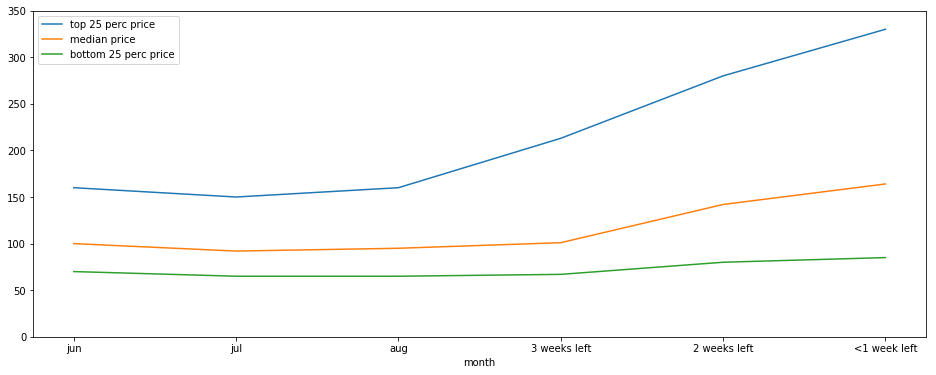

In [151]:
(
    pd.concat([q1_prices, median_prices, q3_prices], axis = 1, sort=False)
    [::-1]
    .plot(figsize = (16, 6), ylim = (0, 350), xticks = range(len(q1_prices)))
);

## How do the number of listing drop

In [155]:
cnt_list = []
for month in months:
        
    sql = '''
        select count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '2018-09-14' and '2018-09-16'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) 
    '''.format('calendar_' + month)
    cnt = pd.read_sql_query(sql, engine)
    cnt_list.append(('booked in ' + month, cnt.loc[0, 'cnt']))

print('number of listings for the weened: ',  cnt_list)

number of listings for the weened:  [('booked in aug', 7222), ('booked in jul', 11508), ('booked in jun', 11372)]


In [156]:
cnt_feb = []
for (date_from, date_to) in dates:
    sql = '''
        select count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from calendar_sep
            where 1=1
                and date between '{}' and '{}'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) 
    '''.format(date_from, date_to)
    cnt = pd.read_sql_query(sql, engine)
    cnt_feb.append((mapper[date_from], cnt.loc[0, 'cnt']))

print('number of listings for the weened: ',  cnt_feb)

number of listings for the weened:  [('<1 week left', 1524), ('2 weeks left', 2269), ('3 weeks left', 2022)]


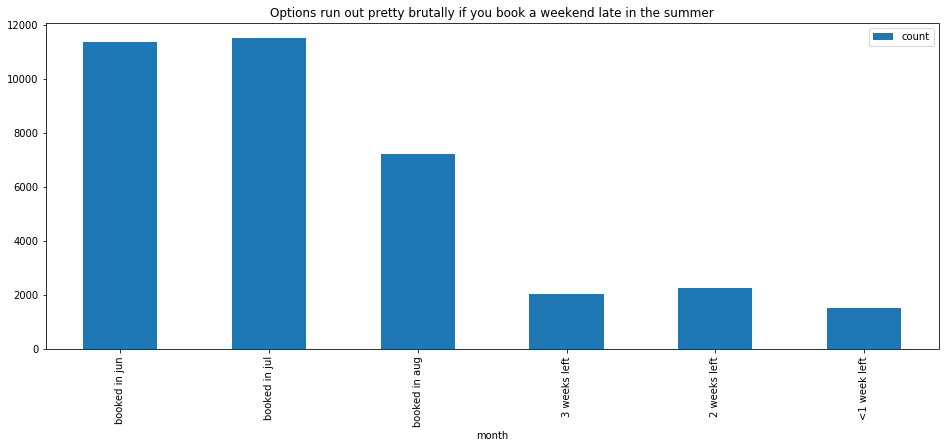

In [161]:
(
    pd
    .concat([
        pd.DataFrame([('<1 week left', 1524), ('2 weeks left', 2269), ('3 weeks left', 2022)], columns = ['month', 'count']),
        pd.DataFrame([('booked in aug', 7222), ('booked in jul', 11508), ('booked in jun', 11372)], columns = ['month', 'count'])
        ])
    .set_index('month')
    [::-1]
    .plot(kind = 'bar', figsize = (16, 6), title = 'Options run out pretty brutally if you book a weekend late in the summer')
);

In [159]:
(
    pd
    .concat([
        pd.DataFrame([('<1 week left', 1524), ('2 weeks left', 2269), ('3 weeks left', 2022)], columns = ['month', 'count']),
        pd.DataFrame([('booked in aug', 7222), ('booked in jul', 11508), ('booked in jun', 11372)], columns = ['month', 'count'])
        ])
    .set_index('month')
    [::-1]
)

,count
month,
booked in jun,11372
booked in jul,11508
booked in aug,7222
3 weeks left,2022
2 weeks left,2269
<1 week left,1524


# Instant bookable
Same approach as above, let's see how the ratio of "instant bookable" places changes over time for a weekend in January and September

## January

In [108]:
dates = [('2019-01-18', '2019-01-20'), ('2019-01-25', '2019-01-27'), ('2019-02-01', '2019-02-03')]
months = ['jan', 'dec', 'nov', 'oct', 'sep']

In [115]:
mapper = {'2019-01-18': '<1 week left', '2019-01-25': '2 weeks left', '2019-02-01':'3 weeks left'}
mapper

{'2019-01-18': '<1 week left',
 '2019-01-25': '2 weeks left',
 '2019-02-01': '3 weeks left'}

In [112]:
instant_list = []
for month in months:
    if month == 'feb':
        continue
    sql = '''
        select instant_bookable, count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '2019-01-18' and '2019-01-20'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) listings
        join {} inst
            on listings.listing_id = inst.id
        group by instant_bookable
        order by instant_bookable
    '''.format('calendar_' + month, 'instant_' + month)
    df = pd.read_sql_query(sql, engine)
    instant_list.append(('booked in ' + month, df.loc[0, 'cnt'], df.loc[1, 'cnt']))

print('instant bookable (f, t): ',  instant_list)

instant bookable (f, t):  [('booked in jan', 2862, 1211), ('booked in dec', 6483, 3665), ('booked in nov', 9639, 5106), ('booked in oct', 9144, 5207), ('booked in sep', 11018, 5931)]


In [116]:
instant_feb = []
for (date_from, date_to) in dates:
    sql = '''
        select instant_bookable, count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '{}' and '{}'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) listings
        join instant inst
            on listings.listing_id = inst.id
        group by instant_bookable
        order by instant_bookable
    '''.format('calendar_jan', date_from, date_to)
    df = pd.read_sql_query(sql, engine)
    instant_feb.append((mapper[date_from], df.loc[0, 'cnt'], df.loc[1, 'cnt']))

print('instant bookable (f, t): ',  instant_feb)

instant bookable (f, t):  [('<1 week left', 2625, 1088), ('2 weeks left', 4767, 2999), ('3 weeks left', 5786, 3631)]


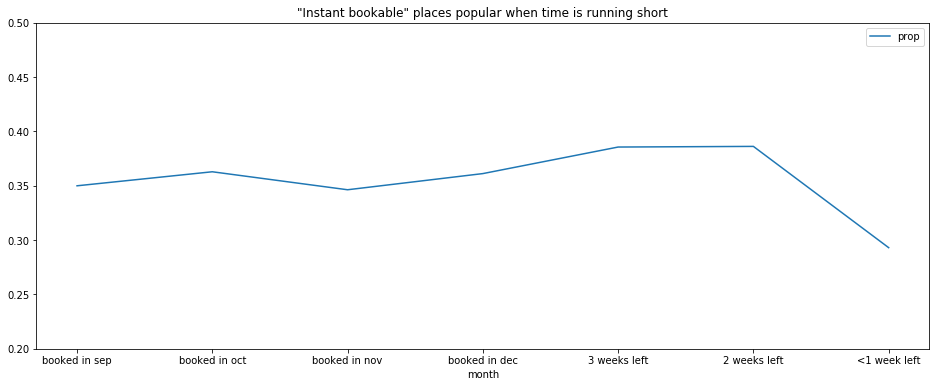

In [134]:
(
    pd
    .concat([
        pd.DataFrame([('<1 week left', 2625, 1088), ('2 weeks left', 4767, 2999), ('3 weeks left', 5786, 3631)], columns = ['month', 'f', 't']),
        pd.DataFrame([('booked in dec', 6483, 3665), ('booked in nov', 9639, 5106), ('booked in oct', 9144, 5207), ('booked in sep', 11018, 5931)], columns = ['month', 'f', 't'])
        ])
    .set_index('month')
    [::-1]
    .assign(prop = lambda x: x.t / (x.t + x.f))
    .plot(y = 'prop', ylim = (0.2, 0.5), title = '"Instant bookable" places popular when time is running short', xticks = range(7), figsize = (16, 6))
           
);

## Septermber

In [128]:
dates = [('2018-09-14', '2018-09-16'), ('2018-09-21', '2018-09-23'), ('2018-09-28', '2018-09-30')]
months = ['aug', 'jul', 'jun']

In [122]:
mapper = {'2018-09-14': '<1 week left', '2018-09-21': '2 weeks left', '2018-09-28':'3 weeks left'}
mapper

{'2018-09-14': '<1 week left',
 '2018-09-21': '2 weeks left',
 '2018-09-28': '3 weeks left'}

In [124]:
instant_list = []
for month in months:
    if month == 'feb':
        continue
    sql = '''
        select instant_bookable, count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '2018-09-14' and '2018-09-16'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) listings
        join {} inst
            on listings.listing_id = inst.id
        group by instant_bookable
        order by instant_bookable
    '''.format('calendar_' + month, 'instant_' + month)
    df = pd.read_sql_query(sql, engine)
    instant_list.append(('booked in ' + month, df.loc[0, 'cnt'], df.loc[1, 'cnt']))

print('instant bookable (f, t): ',  instant_list)

instant bookable (f, t):  [('booked in aug', 5152, 2070), ('booked in jul', 8255, 3253), ('booked in jun', 7923, 3449)]


In [129]:
instant_feb = []
for (date_from, date_to) in dates:
    sql = '''
        select instant_bookable, count(*) as cnt
        from (
            select listing_id, min(price_usd) as price_per_night
            from {}
            where 1=1
                and date between '{}' and '{}'
            group by listing_id
            having max(available) == 't'
                and min(available) == 't'
            ) listings
        join instant inst
            on listings.listing_id = inst.id
        group by instant_bookable
        order by instant_bookable
    '''.format('calendar_sep', date_from, date_to)
    df = pd.read_sql_query(sql, engine)
    instant_feb.append((mapper[date_from], df.loc[0, 'cnt'], df.loc[1, 'cnt']))

print('instant bookable (f, t): ',  instant_feb)

instant bookable (f, t):  [('<1 week left', 710, 269), ('2 weeks left', 990, 493), ('3 weeks left', 924, 327)]


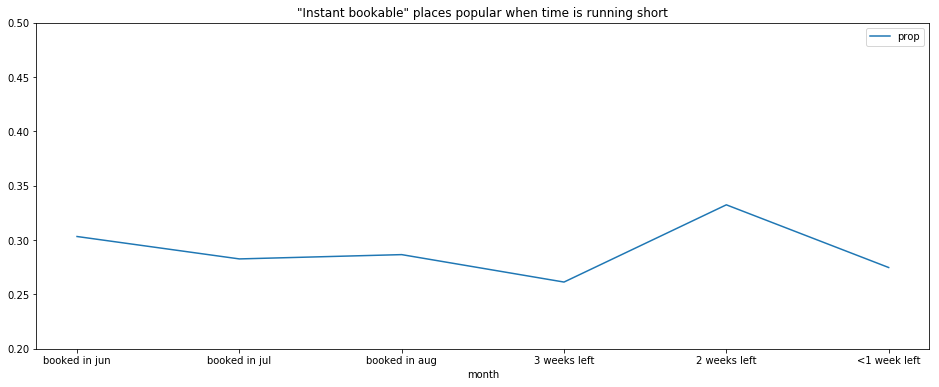

In [132]:
(
    pd
    .concat([
        pd.DataFrame([('<1 week left', 710, 269), ('2 weeks left', 990, 493), ('3 weeks left', 924, 327)], columns = ['month', 'f', 't']),
        pd.DataFrame([('booked in aug', 5152, 2070), ('booked in jul', 8255, 3253), ('booked in jun', 7923, 3449)], columns = ['month', 'f', 't'])
        ])
    .set_index('month')
    [::-1]
    .assign(prop = lambda x: x.t / (x.t + x.f))
    .plot(y = 'prop', ylim = (0.2, 0.5), title = '"Instant bookable" places popular when time is running short', xticks = range(6), figsize = (16, 6))
           
);

# Some more sanity checks for the price trends
Do the trends hold even for the different room types?  

Considering the trends (entire apartments are more popular) of the median, top and bottom quartile of the prices, **it turns out that everything checks out**

In [28]:
medians = pd.DataFrame(columns = ['Entire home/apt', 'Private room', 'Shared room'])
for month in months[::-1]:
    if month == 'feb':
        continue
    medians = medians.append(
        pd
        .read_sql_query('''
                    select room_type, listing_id, min(price_usd) as price_per_night
                    from {} cal
                    join room_types rooms
                        on cal.listing_id = rooms.id
                    where 1=1
                        and date between '{}' and '{}'
                        and room_type != 'Shared room'
                    group by listing_id, room_type
                    having max(available) == 't'
                        and min(available) == 't'
        '''.format('calendar_' + month, '2019-02-08', '2019-02-10'), con=engine)
        .pivot(index = 'listing_id', columns = 'room_type', values = 'price_per_night')
        .median()
        .to_frame()
        .rename(columns = {0: 'booked in ' + month})
        .T
    , sort=False
    )

In [29]:
mapper = {'2019-02-08': '<1 week left', '2019-02-15': '2 weeks left', '2019-02-22': '3 weeks left'}

In [30]:
for (date_from, date_to) in dates[::-1]:
    medians = medians.append(
        pd
        .read_sql_query('''
                    select room_type, listing_id, min(price_usd) as price_per_night
                    from {} cal
                    join room_types rooms
                        on cal.listing_id = rooms.id
                    where 1=1
                        and date between '{}' and '{}'
                        and room_type != 'Shared room'
                    group by listing_id, room_type
                    having max(available) == 't'
                        and min(available) == 't'
        '''.format('calendar_feb', date_from, date_to), con=engine)
        .pivot(index = 'listing_id', columns = 'room_type', values = 'price_per_night')
        .median()
        .to_frame()
        .rename(columns = {0: mapper[date_from]})
        .T
    , sort=False)

In [31]:
(
    medians
    .iplot(filename = 'paris_median_price_per_room_type', 
           mode = 'lines+markers',
           layout = graph_objs.Layout(yaxis = dict(range = (0, 150), tickformat = '$.0f'), 
                                      hovermode = 'closest',
                                      title = '<b>Median price is surprisingly stable as the date comes closer</b><br>Nightly price for a February weekend in Paris booked at different times'
                                     )
          )
)

In [32]:
low_quartile = pd.DataFrame(columns = ['Entire home/apt', 'Private room', 'Shared room'])
for month in months[::-1]:
    if month == 'feb':
        continue
    low_quartile = low_quartile.append(
        pd
        .read_sql_query('''
                    select room_type, listing_id, min(price_usd) as price_per_night
                    from {} cal
                    join room_types rooms
                        on cal.listing_id = rooms.id
                    where 1=1
                        and date between '{}' and '{}'
                        and room_type != 'Shared room'
                    group by listing_id, room_type
                    having max(available) == 't'
                        and min(available) == 't'
        '''.format('calendar_' + month, '2019-02-08', '2019-02-10'), con=engine)
        .pivot(index = 'listing_id', columns = 'room_type', values = 'price_per_night')
        .quantile(.25)
        .to_frame()
        .rename(columns = {0.25: 'booked in ' + month})
        .T
    , sort=False
    )

In [33]:
for (date_from, date_to) in dates[::-1]:
    low_quartile = low_quartile.append(
        pd
        .read_sql_query('''
                    select room_type, listing_id, min(price_usd) as price_per_night
                    from {} cal
                    join room_types rooms
                        on cal.listing_id = rooms.id
                    where 1=1
                        and date between '{}' and '{}'
                        and room_type != 'Shared room'
                    group by listing_id, room_type
                    having max(available) == 't'
                        and min(available) == 't'
        '''.format('calendar_feb', date_from, date_to), con=engine)
        .pivot(index = 'listing_id', columns = 'room_type', values = 'price_per_night')
        .quantile(.25)
        .to_frame()
        .rename(columns = {0.25: mapper[date_from]})
        .T
    , sort=False
    )

In [34]:
(
    low_quartile
    .iplot(filename = 'paris_q1_price_per_room_type', 
           mode = 'lines+markers',
           layout = graph_objs.Layout(yaxis = dict(range = (0, 100), tickformat = '$.0f'), 
                                      hovermode = 'closest',
                                      title = '<b>Bottom 25 percentile price goes up 10% over time</b><br>Nightly price for a February weekend in Paris booked at different times'
                                     )
          )
)

In [67]:
med = pd.DataFrame(columns = ['Entire home/apt', 'Private room', 'Shared room'])
for month in months[::-1]:
    if month == 'feb':
        continue
    med = med.append(
        pd
        .read_sql_query('''
                    select room_type, listing_id, min(price_usd) as price_per_night
                    from {} cal
                    join room_types rooms
                        on cal.listing_id = rooms.id
                    where 1=1
                        and date between '{}' and '{}'
                        and room_type != 'Shared room'
                    group by listing_id, room_type
                    having max(available) == 't'
                        and min(available) == 't'
        '''.format('calendar_' + month, '2019-02-08', '2019-02-10'), con=engine)
        .pivot(index = 'listing_id', columns = 'room_type', values = 'price_per_night')
        .mean()
        .to_frame()
        .rename(columns = {0.5: 'booked in ' + month})
        .T
    , sort=False
    )
med

,Entire home/apt,Private room,Shared room
0,153.340733,126.819730,NaN
0,160.458400,129.511640,NaN
0,165.976016,130.903509,NaN
0,164.102659,126.181939,NaN
0,173.024010,131.934704,NaN


In [60]:
high_quartile = pd.DataFrame(columns = ['Entire home/apt', 'Private room', 'Shared room'])
for month in months[::-1]:
    if month == 'feb':
        continue
    high_quartile = high_quartile.append(
        pd
        .read_sql_query('''
                    select room_type, listing_id, min(price_usd) as price_per_night
                    from {} cal
                    join room_types rooms
                        on cal.listing_id = rooms.id
                    where 1=1
                        and date between '{}' and '{}'
                        and room_type != 'Shared room'
                    group by listing_id, room_type
                    having max(available) == 't'
                        and min(available) == 't'
        '''.format('calendar_' + month, '2019-02-08', '2019-02-10'), con=engine)
        .pivot(index = 'listing_id', columns = 'room_type', values = 'price_per_night')
        .quantile(.75)
        .to_frame()
        .rename(columns = {0.75: 'booked in ' + month})
        .T
    , sort=False
    )

In [61]:
for (date_from, date_to) in dates[::-1]:
    high_quartile = high_quartile.append(
        pd
        .read_sql_query('''
                    select room_type, listing_id, min(price_usd) as price_per_night
                    from {} cal
                    join room_types rooms
                        on cal.listing_id = rooms.id
                    where 1=1
                        and date between '{}' and '{}'
                        and room_type != 'Shared room'
                    group by listing_id, room_type
                    having max(available) == 't'
                        and min(available) == 't'
        '''.format('calendar_feb', date_from, date_to), con=engine)
        .pivot(index = 'listing_id', columns = 'room_type', values = 'price_per_night')
        .quantile(.75)
        .to_frame()
        .rename(columns = {0.75: mapper[date_from]})
        .T
    , sort=False
    )

In [62]:
high_quartile

,Entire home/apt,Private room,Shared room
booked in sep,170.0,129.00,NaN
booked in oct,180.0,140.00,NaN
booked in nov,183.0,147.75,NaN
booked in dec,180.0,136.50,NaN
booked in jan,185.0,145.00,NaN
3 weeks left,190.0,145.75,NaN
2 weeks left,200.0,143.00,NaN
<1 week left,200.0,149.00,NaN


In [64]:
(
    high_quartile
    .iplot(filename = 'paris_q3_price_per_room_type', 
           mode = 'lines+markers',
           layout = graph_objs.Layout(yaxis = dict(range = (0, 210), tickformat = '$.0f'), 
                                      hovermode = 'closest',
                                      title = '<b>Top 25 percentile price goes up 10% over time</b><br>Nightly price for a February weekend in Paris booked at different times'
                                     )
          )
)